## Preprocess

In [1]:
file = open("./data/mevlana.txt","r",encoding="utf-8")
data=file.read()

In [2]:
# considering punctuations as word
import string
punct = ".,!?/’:\";\-–“”'"
data = data.lower()
data = data.replace("\n"," ")
tmp = ""

for i in data:
    if i.isalpha() or i == " ":
        tmp = tmp+i
    elif i in punct:
        tmp = tmp+" "+i+" "
data = tmp

In [3]:
max_features = 50000  # Number of words 
n_word = 5 # Number of word as input to model
embedding_dim = 300 # Embedding vector dimension

## Tokenization

In [4]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features,lower=False,filters="")

In [5]:
tokenizer.fit_on_texts([data])

In [6]:
data_encoded = tokenizer.texts_to_sequences([data])[0]

In [7]:
vocab_size = len(tokenizer.word_index)+1
print(f"Vocabluary size: {vocab_size}")

Vocabluary size: 28960


## Model Input&Output

In [8]:
X = []
y = []
for i in range(n_word, len(data_encoded)):
    X.append(data_encoded[i-n_word:i])
    y.append(data_encoded[i])

In [9]:
import numpy as np
from keras.utils import to_categorical
X = np.array(X)
y = to_categorical(y, num_classes=vocab_size)

## Embedding

In [10]:
# pretrained Turkish-GloVe embedding
# source https://github.com/inzva/Turkish-GloVe
embedding = open("embeddings/vectors.txt",encoding="utf-8")

In [11]:
#Creating embedding dictionary
embedding_dict= {}
for i in embedding:
    line = i.split(' ')
    line[-1]=line[-1].replace('\n','')
    embedding_dict[''+line[0]]=line[1:]

In [12]:
len(embedding_dict)

253832

In [13]:
keys = embedding_dict.keys()
unk_token = np.zeros(300,)
#Using unk_token(average of all vetors) for the words not in embedding ectors
for i in keys:
    unk_token = unk_token + np.array(embedding_dict[i],float)
unk_token = unk_token / len(keys)

In [14]:
# creating embedding matrix
counter = 0
unk_words = []
embedding_matrix = np.zeros((vocab_size, 300))
embedding_matrix[0] = np.zeros(300,)
for word, i in tokenizer.word_index.items():
    if i == vocab_size:
        break
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is  None:
        #words not in embedding considered unk token
        embedding_vector = unk_token.tolist()
        counter = counter + 1
        unk_words.append(word)
    embedding_matrix[i] = embedding_vector

In [15]:
embedding_matrix.shape

(28960, 300)

In [16]:
print(f"Number of unk token usage: {counter}")

Number of unk token usage: 7899


In [17]:
unk_words[:10]

['’',
 '“',
 '”',
 'mecâlis',
 'ıssı',
 '–',
 'fîh',
 'duacının',
 'husâmeddin',
 'barsîsa']

## Model

In [18]:
from keras.models import Sequential
from keras.layers import LSTM,RNN,Dense,Embedding,Input,Flatten
model = Sequential()
model.add(Input(shape=(5,)))
model.add(Embedding(input_dim = vocab_size , weights =[embedding_matrix], output_dim = embedding_dim, input_length = n_word, trainable=False))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128,return_sequences = True))
model.add(Dense(256,activation = "relu"))
model.add(Dense(128,activation = "relu"))
model.add(Flatten())
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 300)            8688000   
_________________________________________________________________
lstm (LSTM)                  (None, 5, 128)            219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
dense (Dense)                (None, 5, 256)            33024     
_________________________________________________________________
dense_1 (Dense)              (None, 5, 128)            32896     
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 28960)             1

# Compile&Train

In [19]:
# call back for stop training at certein accuracy threshold
from keras.callbacks import Callback
class My_Callback(Callback):
    def __init__(self, threshold):
        super(My_Callback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["categorical_accuracy"]
        if acc >= self.threshold:
            print(f"Accuracy reach over {self.threshold}% terminating train process.")
            self.model.stop_training = True

In [23]:
#categorical_accuracy
cb = My_Callback(0.95)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history = model.fit(X, y, batch_size=4096, epochs=500, callbacks=[cb])

Epoch 1/500
43/43 [==============================] - 41s 801ms/step - loss: 9.2970 - categorical_accuracy: 0.0438
Epoch 2/500
43/43 [==============================] - 28s 647ms/step - loss: 7.6196 - categorical_accuracy: 0.0871
Epoch 3/500
43/43 [==============================] - 25s 587ms/step - loss: 7.5447 - categorical_accuracy: 0.0876
Epoch 4/500
43/43 [==============================] - 25s 579ms/step - loss: 7.4958 - categorical_accuracy: 0.0870
Epoch 5/500
43/43 [==============================] - 25s 584ms/step - loss: 7.3555 - categorical_accuracy: 0.0891
Epoch 6/500
43/43 [==============================] - 25s 589ms/step - loss: 7.1404 - categorical_accuracy: 0.0924
Epoch 7/500
43/43 [==============================] - 25s 588ms/step - loss: 6.8720 - categorical_accuracy: 0.1007
Epoch 8/500
43/43 [==============================] - 25s 589ms/step - loss: 6.5869 - categorical_accuracy: 0.1098
Epoch 9/500
43/43 [==============================] - 25s 590ms/step - loss: 6.3331 - cat

Epoch 143/500
43/43 [==============================] - 26s 592ms/step - loss: 0.5836 - categorical_accuracy: 0.8371
Epoch 144/500
43/43 [==============================] - 25s 588ms/step - loss: 0.5776 - categorical_accuracy: 0.8381
Epoch 145/500
43/43 [==============================] - 25s 587ms/step - loss: 0.5646 - categorical_accuracy: 0.8435
Epoch 146/500
43/43 [==============================] - 25s 584ms/step - loss: 0.5722 - categorical_accuracy: 0.8425
Epoch 147/500
43/43 [==============================] - 26s 594ms/step - loss: 0.5630 - categorical_accuracy: 0.8432
Epoch 148/500
43/43 [==============================] - 26s 597ms/step - loss: 0.5561 - categorical_accuracy: 0.8449
Epoch 149/500
43/43 [==============================] - 25s 591ms/step - loss: 0.5427 - categorical_accuracy: 0.8502
Epoch 150/500
43/43 [==============================] - 26s 600ms/step - loss: 0.5540 - categorical_accuracy: 0.8452
Epoch 151/500
43/43 [==============================] - 26s 597ms/step - 

## Evaluation 

In [20]:
#model.save_weights("model/tr-lang-model.h5")
model.load_weights("model/tr-lang-model.h5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.evaluate(X,y,batch_size = 4096)

43/43 [==============================] - 22s 435ms/step - loss: 0.1404 - categorical_accuracy: 0.9665


[0.15542151033878326, 0.9619872570037842]

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.title('Training  accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'r', label='Training loss')
    plt.title('Training loss')
    plt.legend()

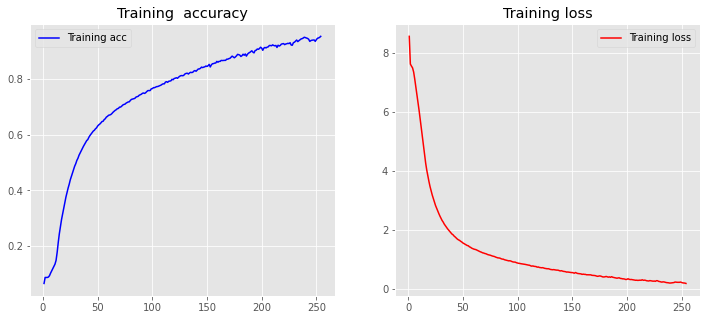

In [28]:
plot_history(history)

To generate sequence basically get seed text and and consider 5 word from right side and ignore others, if its less than 5 padding(pre) from left side after that for each 5 word model predict 1 word. After prediction we feed 4 word from previous input and previously predicted word as 5th word and so on.

In [29]:
# for dynamic printing
from IPython.display import display, clear_output
# padding for fixed input size
from keras.preprocessing.sequence import pad_sequences
# generating sequence from language model
def generate_sequence(tokenizer, max_output_seq_len, n_input_words, seed_text, model):
    model_input = seed_text
    
    # generate given max amount of word
    for _ in range(max_output_seq_len):
        # tokenize input text
        model_input_encoded = tokenizer.texts_to_sequences([model_input])[0]
        # pre-padding for fixed length(n_input_words)
        model_input_encoded = pad_sequences([model_input_encoded], maxlen=n_input_words, padding='pre')
        # predict probabilties for each word in vocab.
        prediction = model.predict(model_input_encoded)[0]
        prediction = np.argmax(prediction)
        # finding predicted word
        predicted_word = list(tokenizer.word_index.keys())[prediction-1]
        model_input = model_input + " " + predicted_word
        display(model_input)
        clear_output(wait=True)
    return model_input

In [30]:
# for dynamic printing
from IPython.display import display, clear_output
# padding for fixed input size
from keras.preprocessing.sequence import pad_sequences
# generating sequence from language model
def generate_sequence_with_random_choice(tokenizer, max_output_seq_len, n_input_words, seed_text, model, acceptance_threshold):
    model_input = seed_text
    
    # generate given max amount of word
    for _ in range(max_output_seq_len):
        # variable countermeasure if threshold too high for prediction
        at = acceptance_threshold
        # tokenize input text
        model_input_encoded = tokenizer.texts_to_sequences([model_input])[0]
        # pre-padding for fixed length(n_input_words)
        model_input_encoded = pad_sequences([model_input_encoded], maxlen=n_input_words, padding='pre')
        # predict probabilties for each word in vocab.
        prediction = model.predict(model_input_encoded)
        # countermeasure if threshold too high for prediction
        if np.max(prediction) < acceptance_threshold:
            at = np.max(prediction)
        # take predicted words with probability higher than the threshold
        prediction = prediction >= at
        # taking index high prob. words(true values)
        possible_words = np.where(prediction)[1]
        # choosing one of possible word
        choosen_index = possible_words[np.random.randint(0,len(possible_words))]
        # getting correspanding key from word index
        predicted_word = list(tokenizer.word_index.keys())[choosen_index-1]
        model_input = model_input + " " + predicted_word
        display(model_input)
        clear_output(wait=True)
        
    return model_input

In [42]:
generate_sequence(tokenizer, 25, n_word, "Ne olursan", model)

'Ne olursan o ’ hicabıdır , bizim bütün bunlar bizim ilk ne demek ey / maddî yolunda şirk olur ; gönülleri mı varsa var ; yoksa hiç'

In [45]:
generate_sequence_with_random_choice(tokenizer, 25, n_word, "Ne olursan", model,acceptance_threshold = 0.3)

'Ne olursan o kötü bütün âlem ıssı , devletler , senin , hıyanet bize arap bile olması . - kötü şems , merhamet üzere yalnız benim ,'

In [46]:
generate_sequence(tokenizer, 150, n_word, "Sen nasıl rızka düşkün", model)

'Sen nasıl rızka düşkün da bu hikâyelerden sahibi , soğuk bir iş , “ durursun . ” hepsi vardır , kuş , nefis iç bir can ! bir de vuslat ayranı yüce muhammed ’ ile selam imdada yetişti . dünyada iki hayırlı ekin , birbirine söz ancak bir varlık var , kuldur de aynı pek büyük ilimden de aynı kur ’ an ’ bir avuç yeter . kitaptan bir işte söyler . bu birisinin şeyler olmazsa yine onu . . . onun , öç alınarak selamlar ve esenlik . size en allah ’ a hamdolsun – hükmünce artık gökyüzü , ayrı az ile bir saray iki kıymetli yarattı ne meydana kalır , onu bir kişiyi verdiği açarlar ; elbette onlar , yüz bin şey üstün devleti göz bin huyları gel . hak teâlâ ’ in lütfudur . fasıl . dost suresi , : . bunların en yüce işlerle kaldı . ey eski er ,'

In [47]:
generate_sequence_with_random_choice(tokenizer, 150, n_word, "Sen nasıl rızka düşkün", model,acceptance_threshold = 0.5)

'Sen nasıl rızka düşkün da bu hikâyelerden sahibi , soğuk bir iş , “ durursun . ” hepsi vardır , kuş , nefis iç bir can ! bir de vuslat ayranı yüce muhammed ’ ile selam imdada yetişti . dünyada iki hayırlı ekin , birbirine söz ancak bir varlık var , kuldur de aynı pek büyük ilimden de aynı kur ’ an ’ bir avuç yeter . kitaptan bir işte söyler . bu birisinin şeyler olmazsa yine onu . . . onun , öç alınarak selamlar ve esenlik . size en allah ’ a hamdolsun – hükmünce artık gökyüzü , ayrı az ile bir saray iki kıymetli yarattı ne meydana kalır , onu bir kişiyi verdiği açarlar ; elbette onlar , yüz bin şey üstün devleti göz bin huyları gel . hak teâlâ ’ in lütfudur . fasıl . dost suresi , : . bunların en yüce işlerle kaldı . ey eski er ,'

In [48]:
generate_sequence(tokenizer, 50, n_word, "Sahildeki kafka", model)

'Sahildeki kafka olan sâhib ’ in durağı olup - kader - i kadar mi penceredeki habib , ayı ayağa , ey gönül celâl ve ey lütuf yaratan . ” , kahır bütün bunlar . şimdi , güzeller sevgilinin geldi ; artık gümüş gibi meydana ve zaman yazı . sihir ’ nuh ehli'